In [1]:
import numpy
from matplotlib import pyplot
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
# load the dataset
dataframe = read_csv('intecleaned-correct.csv',usecols=[1,2,4,5,6,7,8,9])
dataset = dataframe.values
#将整型变为float
dataset = dataset.astype('float32')
dataframe.head()

,短期预测功率,短期预测湿度,短期预测风向,短期预测温度,短期预测气压,实际功率,实际风速,短期预测风速
0,34.41,75,41,14.7,1008,28.59,8.50,8.864167
1,33.71,75,40,14.7,1008,29.80,8.75,8.764167
2,33.01,75,39,14.6,1008,23.80,7.78,8.664167
3,32.32,75,38,14.5,1008,23.63,7.89,8.564167
4,31.66,75,38,14.5,1008,26.98,7.69,8.464167


In [3]:
def create_dataset(dataset, look_back,look_lag,data_step):
    main_dataX, main_dataY ,auxi_dataX,auxi_dataY= [], [],[],[]
    for i in range(0,len(dataset)-look_back-look_lag+1,data_step):
        a = dataset[i:(i+look_back), 1:8] #前一天的短期预测功率、短期预测湿度、短期预测风向、短期预测温度、
                                        #短期预测气压、实际功率、实际风速都作为输入特征（共7个）
        c = dataset[(i+look_back):(i+look_back+look_lag),1:5]#当天的短期预测功率、短期预测湿度、短期预测风向、短期预测温度、短期预测气压作为特征（共4个）
        d = dataset[(i+look_back):(i+look_back+look_lag),7:8]#当天短期预测风速作为特征（共1个）
        e = numpy.hstack([a,c])
        e = numpy.hstack([d,e])#把上面的特征都合在一起，共12个特征
        main_dataX.append(e) #主要输入
        b = dataset[(i+look_back):(i+look_back+look_lag),5]
        main_dataY.append(b) #主要输出 需要预测的功率数据
    return numpy.array(main_dataX), numpy.array(main_dataY)#,numpy.array(auxi_dataX),numpy.array(auxi_dataY)

In [4]:
# fix random seed for reproducibility
numpy.random.seed(7)
# normalize the dataset
scaler_y = MinMaxScaler(feature_range=(0, 1))#功率数据归一化，之后还原预测结果要用
Y = scaler_y.fit_transform(dataset[:,5:6])

scaler_y1 = MinMaxScaler(feature_range=(0, 1))#风速数据归一化
Y1 = scaler_y1.fit_transform(dataset[:,6:7])

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
look_back = 16
look_lag = 16
train_size = 364*96
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
train_mainX, train_mainY = create_dataset(train, look_back,look_lag,4)#,train_auxiX,train_auxiY
test_mainX, test_mainY = create_dataset(test, look_back,look_lag,16)#,test_auxiX,test_auxiY

# reshape input to be [samples, time steps, features]
train_mainX = numpy.reshape(train_mainX, (train_mainX.shape[0], look_back, 12))

test_mainX = numpy.reshape(test_mainX, (test_mainX.shape[0], look_back, 12))

In [6]:
train_mainX.shape

(8729, 16, 12)

In [7]:
!pip install keras==2.2.4

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
     |████████████████████████████████| 312 kB 781 kB/s eta 0:00:01


In [7]:
import keras
from keras.models import Model
from keras.layers import Dense,Input,Masking
from keras.layers import LSTM,Conv1D,MaxPooling1D,GRU
from keras.layers import Dropout
from keras.layers import Activation,concatenate
from keras.utils import to_categorical
from keras.models import load_model
from keras.engine import Layer
import keras.backend as K
from keras.layers import Multiply
from keras.layers.core import *
from keras.models import *
from keras.regularizers import l2
#输入层
main_input = Input(shape=(train_mainX.shape[1],train_mainX.shape[2]))
#auxi_input = Input(shape=(train_auxiX.shape[1],train_auxiX.shape[2]))
#模型1#
#三层卷积层
convolution1 = Conv1D(8, kernel_size=5, strides=1, activation='relu', padding='same')(main_input)
Pool1 = MaxPooling1D(pool_size=3)(convolution1)
convolution2 = Conv1D(8, kernel_size=5, strides=1, activation='relu', padding='same')(Pool1)
Pool2 = MaxPooling1D(pool_size=3)(convolution2)
#convolution3 = Conv1D(8, kernel_size=3, strides=1, activation='relu', padding='same')(convolution2)
Flat = Flatten()(Pool2)
Drop2 = Dropout(0.5)(Flat)

#模型2
#两层LSTM
LSTM1 = GRU(units=100, return_sequences=True)(main_input) 
#Drop3 = Dropout(0.2)(LSTM1)
LSTM2 = GRU(units=48, return_sequences=False)(LSTM1)
Drop1 = Dropout(0.5)(LSTM2)
#LSTM3 = LSTM(units=48, return_sequences=False)(LSTM2)
#attention_mul = attention_3d_block(LSTM2)

#模型1和模型2连接起来
con = concatenate([Drop2,Drop1])
#Flat = Flatten()(con)
main_output = Dense(units = look_lag)(con)#主要输出
#main_output = Dropout(0.2)(main_output)

model = Model(inputs=main_input, outputs=main_output)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(train_mainX,train_mainY, validation_split=0.33,epochs=100, batch_size=120, shuffle=True)

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5848 samples, validate on 2881 samples
Epoch 1/100





5848/5848 [==============================] - 7s 1ms/step - loss: 0.0518 - val_loss: 0.0162
Epoch 2/100
5848/5848 [==============================] - 2s 380us/step - loss: 0.0242 - val_loss: 0.0154
Epoch 3/100
5848/5848 [==============================] - 2s 380us/step - loss: 0.0201 - val_loss: 0.0120
Epoch 4/100
5848/5848 [==============================] - 2s 375us/step - loss: 0.0179 - val_loss: 0.0122
Epoch 5/100
5848/5848 [==============================] - 2s 375us/step - loss: 0.0167 - val_loss: 0.0123
Epoch 6/100
5848/5848 [==============================] - 2s 374us/step - loss: 0.0156 - val_loss: 0.0111
Epoch 7/100
5848/5848 [==============================] - 2s 372us/step - loss: 0.0148 - val_loss: 0.0

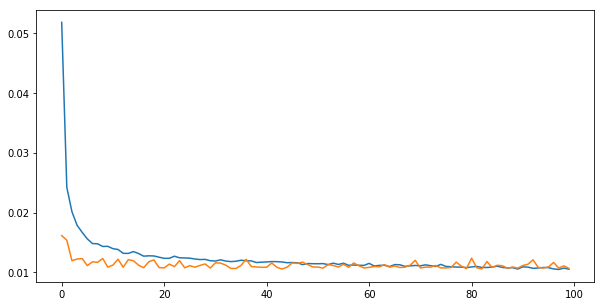

In [8]:
pyplot.figure(figsize=(10,5))
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['val_loss'], label='val_loss')

In [9]:
# 执行预测
testPredict = model.predict(test_mainX)

In [10]:
testPredict.shape

(540, 16)

In [11]:
testPredict = testPredict.reshape(-1,1)
testPredict = scaler_y.inverse_transform(testPredict)

In [12]:
testPredict

array([[30.48677 ],
       [30.511454],
       [30.26011 ],
       ...,
       [36.17858 ],
       [35.904884],
       [35.73591 ]], dtype=float32)

In [13]:
test_mainY = test_mainY.reshape(-1,1)
test_mainY = scaler_y.inverse_transform(test_mainY)
test_mainY.shape

(8640, 1)

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
def result(testY,testPredict):
    mse = mean_squared_error(testY,testPredict)
    mae = mean_absolute_error(testY,testPredict)
    r_square = r2_score(testY,testPredict)
    print("MSE:",mse)
    print("MAE:",mae)
    print("R_Square:",r_square)
    rmse = math.sqrt(mse)
    print("RMSE:",rmse)
    capacity = 49.5
    print("NRMSE:",1 - rmse/capacity)
    p_hme = 0
    whole_power = 49.5
    for l in range(testY.shape[0]):
        if testY[l] <= whole_power * 0.03 and testPredict[l] <= whole_power * 0.03:
            continue
        p_hme = p_hme + abs(testY[l] / (testY[l] + testPredict[l]) - 0.5) * abs(testPredict[l] -testY[l]) / np.sum(np.abs(testPredict - testY))
    p_hme =  1 - 2 * p_hme
    print('E', p_hme)

In [15]:
predictions_1 = testPredict[0:31*96,0]
predictions_2 = testPredict[31*96:59*96,0]
predictions_3 = testPredict[59*96:90*96,0]

test_labels_1 = test_mainY[0:31*96,0]
test_labels_2 = test_mainY[31*96:59*96,0]
test_labels_3 = test_mainY[59*96:90*96,0]

print("2019年1-3月结果：")
result(test_mainY,testPredict)
print("2019年1月结果：")
result(test_labels_1,predictions_1)
print("2019年2月结果：")
result(test_labels_2,predictions_2)
print("2019年3月结果：")
result(test_labels_3,predictions_3)

2019年1-3月结果：
MSE: 26.41263
MAE: 3.6076982
R_Square: 0.8549509855575156
RMSE: 5.139321947609116
NRMSE: 0.8961753141897149
E [0.74121475]
2019年1月结果：
MSE: 28.010866
MAE: 3.8394868
R_Square: 0.8290572073630317
RMSE: 5.2925292786305045
NRMSE: 0.8930802165933232
E 0.7693337929936483
2019年2月结果：
MSE: 25.321568
MAE: 3.5582073
R_Square: 0.8644149037867391
RMSE: 5.032054007599719
NRMSE: 0.8983423432808137
E 0.7473158135094312
2019年3月结果：
MSE: 25.79988
MAE: 3.420611
R_Square: 0.8614511886278455
RMSE: 5.079358136034186
NRMSE: 0.8973867043225418
E 0.7039205691660517


In [16]:
#原系统准确率
testorin=dataframe.values[train_size:,0]
testorin=testorin.reshape(8640,1)
systempredictions_1 = testorin[0:31*96,0]
systempredictions_2 = testorin[31*96:59*96,0]
systempredictions_3 = testorin[59*96:90*96,0]
#原始系统准确率
print("原始系统准确率:")
print("2019年1-3月结果：")
result(test_mainY,testorin)
print("2019年1月结果：")
result(test_labels_1,systempredictions_1)
print("2019年2月结果：")
result(test_labels_2,systempredictions_2)
print("2019年3月结果：")
result(test_labels_3,systempredictions_3)

原始系统准确率:
2019年1-3月结果：
MSE: 38.90323077467954
MAE: 4.73843288221362
R_Square: 0.7863569507222773
RMSE: 6.237245447685985
NRMSE: 0.8739950414608892
E [0.66917906]
2019年1月结果：
MSE: 38.48454371279563
MAE: 4.870769504471107
R_Square: 0.7651391491589099
RMSE: 6.203591194847999
NRMSE: 0.8746749253566061
E 0.7053141024294813
2019年2月结果：
MSE: 43.47097008356602
MAE: 5.008162211467779
R_Square: 0.7672333948800686
RMSE: 6.593251859558076
NRMSE: 0.8668029927362004
E 0.6714997321255596
2019年3月结果：
MSE: 35.19621781563373
MAE: 4.3624697690168945
R_Square: 0.8109915717941774
RMSE: 5.932640037591504
NRMSE: 0.8801486861092626
E 0.6264273692486862


In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 12)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16, 8)        488         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 5, 8)         0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 5, 8)         328         max_pooling1d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [18]:
new_data = numpy.hstack([test_mainY,testorin,testPredict])

In [19]:
new_data

array([[27.67000008, 32.24      , 30.48677063],
       [33.79000092, 32.09      , 30.51145363],
       [30.23999977, 31.94      , 30.26011086],
       ...,
       [38.43999863, 36.1       , 36.17858124],
       [37.79999924, 36.03      , 35.90488434],
       [39.36000061, 35.96      , 35.73590851]])

In [20]:
import pandas as pd
new_data = pd.DataFrame(new_data,columns= ['实际功率','原系统预测功率','超短期预测功率'])

In [21]:
new_data.to_csv('cnn_gru-ushort-89.61.csv', index=False, sep=',')

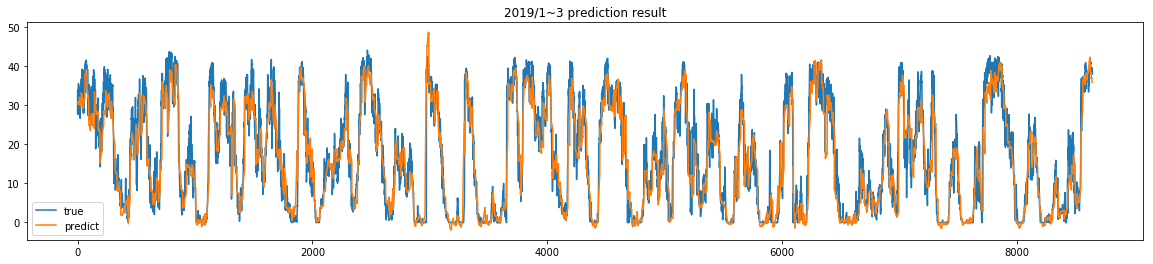

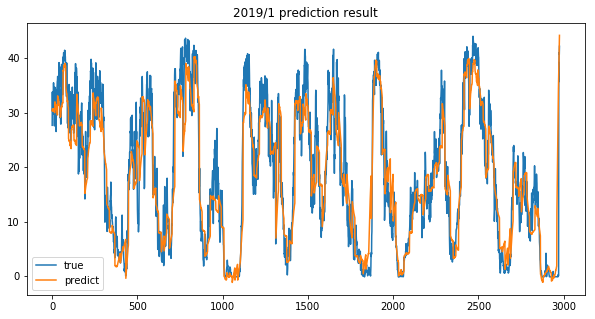

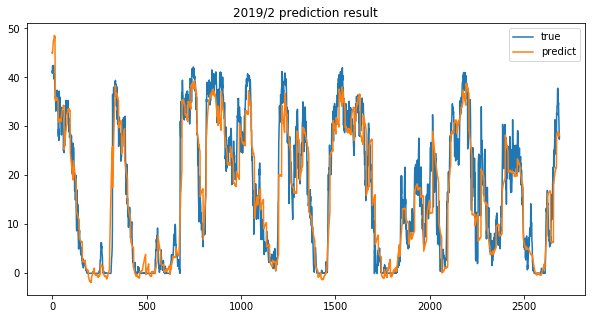

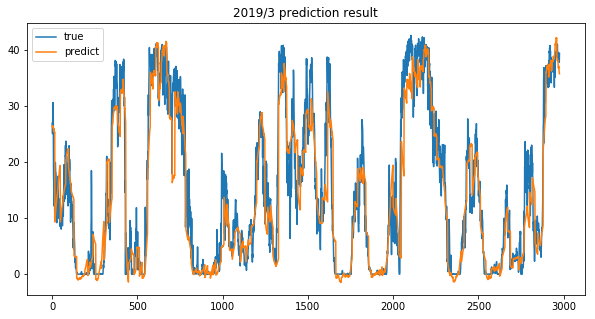

In [22]:
pyplot.figure(figsize=(20,4))
pyplot.plot(test_mainY, label='true')
pyplot.plot(testPredict, label='predict')
pyplot.title('2019/1~3 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_1, label='true')
pyplot.plot(predictions_1, label='predict')
pyplot.title('2019/1 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_2, label='true')
pyplot.plot(predictions_2, label='predict')
pyplot.title('2019/2 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_3, label='true')
pyplot.plot(predictions_3, label='predict')
pyplot.title('2019/3 prediction result')
pyplot.legend()
pyplot.show()

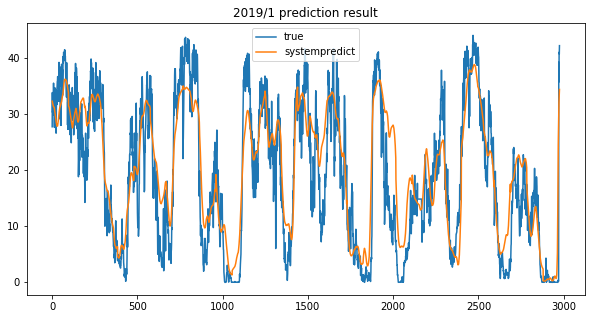

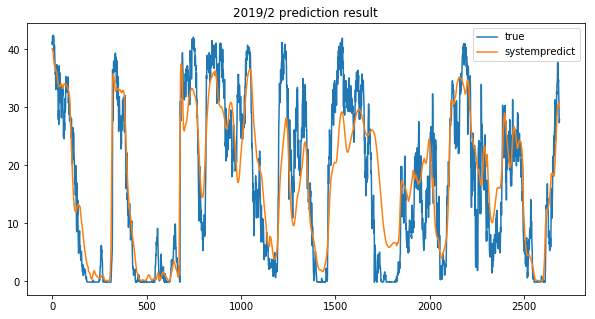

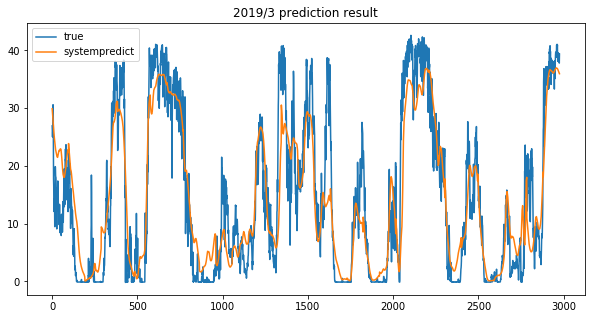

In [24]:
pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_1, label='true')
pyplot.plot(systempredictions_1, label='systempredict')
pyplot.title('2019/1 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_2, label='true')
pyplot.plot(systempredictions_2, label='systempredict')
pyplot.title('2019/2 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_3, label='true')
pyplot.plot(systempredictions_3, label='systempredict')
pyplot.title('2019/3 prediction result')
pyplot.legend()
pyplot.show()